# MovieLens Recommendation System

In the age of streaming, it can be overwhelming trying to find the next show to binge on with thousands of titles available at our fingertips. Recommender systems help guide our search by filtering all this information and returning a list of titles according to our preferences. 

There are 2 types of information filtering are:
1. Content Filtering
2. Collaborative Filtering (CF)

Today's recommender systems implement both methods, making predictions on a user's preferences based on the item's attributes and common preferences among other users.

# Objective
Create a hybridized recommender system that uses content filtering and CF to dynamically recommend titles based on a user's preferences.

# 1. Imports

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD

from fuzzywuzzy import process

import warnings
warnings.filterwarnings('ignore')

# 2. Load Data
Dataset: https://grouplens.org/datasets/movielens/

In [2]:
movies = pd.read_csv('/Users/kevintie/Desktop/data_projects/projects/movie_rec_project/data/ml-latest-small/movies.csv')
ratings = pd.read_csv('/Users/kevintie/Desktop/data_projects/projects/movie_rec_project/data/ml-latest-small/ratings.csv')

In [3]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


Based on the dataframes, the key features I chose are: rating and genre.

# 3. Exploratory Data Analysis

In [5]:
n_ratings = len(ratings.rating)
n_movies = ratings.movieId.nunique()
n_users = ratings.userId.nunique()

print(f'Number of ratings: {n_ratings}')
print(f'Number of movies: {n_movies}')
print(f'Number of users: {n_users}')
print(f'Average number of ratings per user: {round(n_ratings / n_users, 2)}')
print(f'Average number of ratings per movie: {round(n_ratings / n_movies, 2)}')

Number of ratings: 100836
Number of movies: 9724
Number of users: 610
Average number of ratings per user: 165.3
Average number of ratings per movie: 10.37


This is a pretty dense dataset ideal for learning purposes. In a real-world scenario, the data would be much more sparse with only a couple viewer interactions.

### Distribution of movie ratings

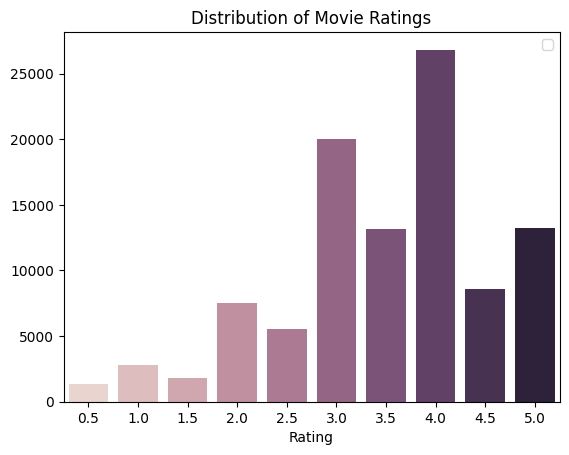

In [6]:
# visualize distribution of movie ratings
sns.countplot(x='rating', data=ratings, hue='rating')

# format visual
plt.xlabel('Rating')
plt.ylabel('')
plt.legend('')
plt.title('Distribution of Movie Ratings')

plt.show()

In [7]:
# determine mean, median, and mode per movie
mean = round(ratings.groupby('movieId')['rating'].mean().mean(), 2)
median = round(ratings.groupby('movieId')['rating'].median().median(), 2)
mode = round(ratings.rating.mode()[0], 2)

print(f'Mean rating per movie: {mean}')
print(f'Median rating per movie: {median}')
print(f'Mode rating per movie: {mode}')

Mean rating per movie: 3.26
Median rating per movie: 3.5
Mode rating per movie: 4.0


In [8]:
# determine mean rating per user
rating_per_user = round(ratings.groupby('userId')['rating'].mean(), 2)
print(f'Mean rating per user: {round(rating_per_user.mean(), 2)}')

Mean rating per user: 3.66


Negative skew towards higher ratings suggest that viewers may choose to rate a title if they really enjoyed it. 

### Most frequently rated movies

First, merge movies and ratings df to access titles.


In [9]:
# merge movie and ratings df
movie_ratings = ratings.merge(movies, on='movieId')
movie_ratings.head()

,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,1,3,4.0,964981247,Grumpier Old Men (1995),Comedy|Romance
2,1,6,4.0,964982224,Heat (1995),Action|Crime|Thriller
3,1,47,5.0,964983815,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
4,1,50,5.0,964982931,"Usual Suspects, The (1995)",Crime|Mystery|Thriller


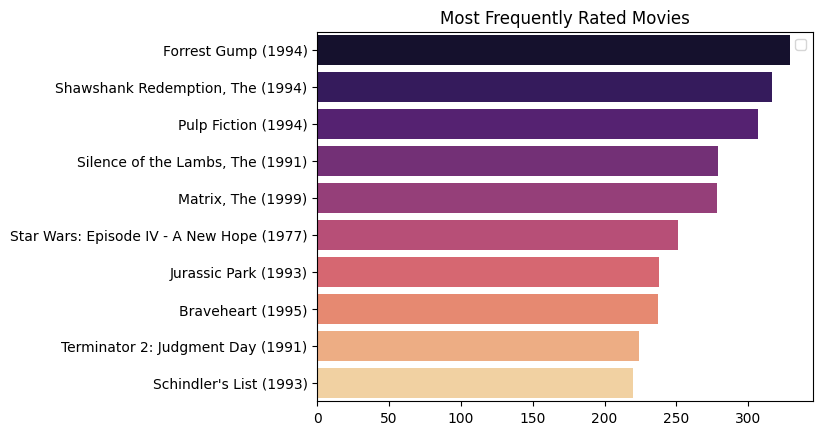

In [10]:
# store title and frequency data into a dataframe
count_df = pd.DataFrame((movie_ratings.title.value_counts()[:10])).reset_index()
count_df.columns = ['title', 'count']

# visualize most frequently rated movies
sns.barplot(x= 'count', y='title', data=count_df, palette='magma')

# format visual
plt.xlabel('')
plt.ylabel('')
plt.legend('')
plt.title('Most Frequently Rated Movies')

plt.show()

Most frequently rated movies are Forrest Gump, Shawshank Redemption, and Pulp Fiction.

### What are the highest/lowest rated movies?

In [11]:
# find the highest rated movie
mean_rating = ratings.groupby('movieId')[['rating']].mean()
highest_rated = mean_rating['rating'].idxmax()

# retreve highest rated movie
movie_ratings[movie_ratings.movieId == highest_rated]

,userId,movieId,rating,timestamp,title,genres
13368,85,53,5.0,889468268,Lamerica (1994),Adventure|Drama
96115,603,53,5.0,963180003,Lamerica (1994),Adventure|Drama


Lamerica is the highest rated movie, but it only has 2 ratings and creates bias in the dataset because this isn't enough ratings to reliably say it's a good movie.

In [12]:
# find the lowest rated movie
lowest_rated = mean_rating['rating'].idxmin()

# retrieve lowest rated movie
movie_ratings[movie_ratings.movieId == lowest_rated]

,userId,movieId,rating,timestamp,title,genres
13633,89,3604,0.5,1520408880,Gypsy (1962),Musical


Gypsy is the lowest rated movie. Similar to Lamerica, it only has 1 rating, which isn't enough to reliably say it's a bad movie. A better approach to getting a more unbiased result would be to use the Bayesian average.

### Bayesian Average

The Bayesian Average is defined as:
$$r_{i} = \frac{C \times m + \sum{reviews}}{C + N}$$

\begin{align*}
r & \text{ - movie's rating} \\
C & \text{ - average number of ratings per movie} \\
m & \text{ - average rating across all movies (global mean rating)} \\
N & \text{ - total number of ratings for movie } i
\end{align*}

Retrieve C and m values.

In [13]:
# first, create a dataframe containing the necessary statistics
movie_stats = pd.DataFrame(ratings.groupby('movieId')['rating'].agg(['count', 'mean']))
movie_stats.head()

,count,mean
movieId,,
1,215,3.920930
2,110,3.431818
3,52,3.259615
4,7,2.357143
5,49,3.071429


In [14]:
# next, create a function that returns the Bayesian average of the dataset
def bayesian_avg(rating):

    '''

    FUNCTION: Calculate the Bayesian average based on a series of ratings for a movie

    ARGS: 
    rating - rating(s) for a movie

    RETURN: 
    scalar

    '''

    # set C and m values
    C = movie_stats['count'].mean()
    m = movie_stats['mean'].mean()

    # calculate Bayesian average based on inputted ratings
    bayesian_avg = (C * m + rating.sum()) / (C + rating.count())

    return round(bayesian_avg, 2)


Apply bayesian_avg function to Lamerica to demo data transformation.

In [15]:
lamerica = pd.Series([5, 5])
print(f'Bayesian average rating for Lamerica is {bayesian_avg(lamerica)}')

Bayesian average rating for Lamerica is 3.54


Apply Bayesian Average across the whole dataset.

In [16]:
# create a dataframe of bayesian averages
bayesian_avg_ratings = ratings.groupby('movieId')['rating'].agg(bayesian_avg).reset_index()
bayesian_avg_ratings.columns = ['movieId', 'bayesian_avg_rating']

# merge bayesian_avg_ratings with movie_stats
movie_stats = movie_stats.merge(bayesian_avg_ratings, on='movieId')
# merge movie_stats dataframe with movies to access titles
movie_stats = movie_stats.merge(movies, on='movieId')

movie_stats.head()

,movieId,count,mean,bayesian_avg_rating,title,genres
0,1,215,3.920930,3.89,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,110,3.431818,3.42,Jumanji (1995),Adventure|Children|Fantasy
2,3,52,3.259615,3.26,Grumpier Old Men (1995),Comedy|Romance
3,4,7,2.357143,2.90,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,49,3.071429,3.10,Father of the Bride Part II (1995),Comedy


### Highest rated movies based on Bayesian averages

In [17]:
# retrieve highest rated movies
movie_stats.sort_values(by='bayesian_avg_rating', ascending=False).head()

,movieId,count,mean,bayesian_avg_rating,title,genres
277,318,317,4.429022,4.39,"Shawshank Redemption, The (1994)",Crime|Drama
659,858,192,4.289062,4.24,"Godfather, The (1972)",Crime|Drama
2224,2959,218,4.272936,4.23,Fight Club (1999),Action|Crime|Drama|Thriller
224,260,251,4.231076,4.19,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi
921,1221,129,4.259690,4.19,"Godfather: Part II, The (1974)",Crime|Drama


The highest rated movies are Shawshank Redemption, Godfather, and Fight Club. This makes more sense as these are films with higher critical acclaim and press.

### Lowest rated movies based on Bayesian averages

In [18]:
# retrieve lowest rated movies
movie_stats.sort_values(by='bayesian_avg_rating').head()

,movieId,count,mean,bayesian_avg_rating,title,genres
1172,1556,19,1.605263,2.19,Speed 2: Cruise Control (1997),Action|Romance|Thriller
2679,3593,19,1.657895,2.22,Battlefield Earth (2000),Action|Sci-Fi
1372,1882,33,1.954545,2.27,Godzilla (1998),Action|Sci-Fi|Thriller
1144,1499,27,1.925926,2.30,Anaconda (1997),Action|Adventure|Thriller
1988,2643,16,1.687500,2.31,Superman IV: The Quest for Peace (1987),Action|Adventure|Sci-Fi


The lowest rated movies are Speed 2, Battlefield Earth, and Godzilla. Godzilla has a 1 of 5 score on Rotten Tomatoes -- yikes. 

## Movie Genre

A glance at the movie genre data tells us it needs to be cleaned in 2 ways:

1. genre strings contain pipes ('|') and need to be split
2. movie titles end with year, which can instead be extracted as another feature (feature engineering)

In [19]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [20]:
# split pipes in genre strings
movies['genres'] = movies['genres'].apply(lambda x: x.split('|'))

movies.head()

,movieId,title,genres
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]"
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]"
2,3,Grumpier Old Men (1995),"[Comedy, Romance]"
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]"
4,5,Father of the Bride Part II (1995),[Comedy]


### Movie genre stats

In [21]:
genre_count = Counter(g for genres in movies['genres'] for g in genres)
print(f'Number of movies genres: {len(genre_count)}')
print(f'Most frequent genres: \n{genre_count.most_common(5)}')

Number of movies genres: 20
Most frequent genres: 
[('Drama', 4361), ('Comedy', 3756), ('Thriller', 1894), ('Action', 1828), ('Romance', 1596)]


### Visualize most common genres

In [22]:
# store genre frequencies into a dataframe
genre_counts_df = pd.DataFrame([genre_count]).T.reset_index()
genre_counts_df.columns = ['genre', 'count']

genre_counts_df.head()

,genre,count
0,Adventure,1263
1,Animation,611
2,Children,664
3,Comedy,3756
4,Fantasy,779


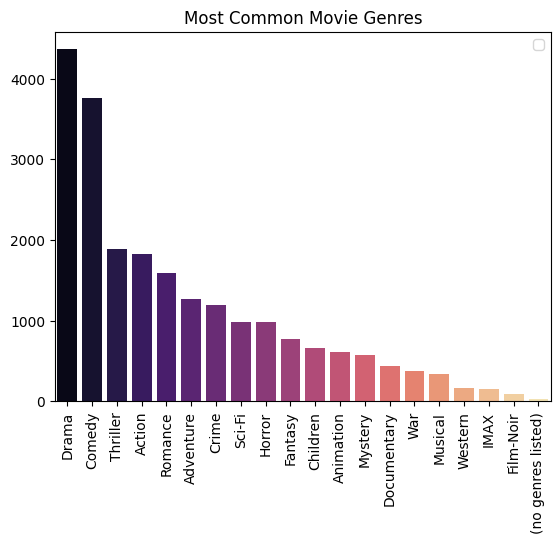

In [23]:
# create a barplot showing most common genres
sns.barplot(x='genre', y='count', data=genre_counts_df, order=genre_counts_df.sort_values(by='count', ascending=False)['genre'], palette='magma')

# rotate plot
plt.xticks(rotation=90)

# format plot
plt.xlabel('')
plt.ylabel('')
plt.legend('')
plt.title('Most Common Movie Genres')

plt.show()

# 4. Data Preprocessing

Use collaborative filtering (CF) to recommend titles to users based on similar user preferences. First, transform data into a user:item matrix (utility matrix) where rows represent users and columns represent titles.

First, we need to create a matrix $X$ and 4 mapper dictionaries to correspond to each user and movie Id:
1. user_mapper: map user Id to user index
2. movie_mapper: map movie Id to movie index
3. user_inv_mapper: map user index to user Id
4. movie_inv_mapper: map movie index to movie Id

In [24]:
def create_X(df):
    '''

    FUNCTION: generate a sparse matrix from the ratings dataframe

    ARGS:  
    df - ratings dataframe containing movie Id, user Id, and rating columns

    RETURN:
    X - utility matrix with 4 mapper dictionaries

    '''
    # store unique user and movie ids into variables
    n_user_id = df['userId'].nunique()
    n_movie_id = df['movieId'].nunique()

    # create mapper dictionaries to label our matrix
    user_mapper = dict(zip(np.unique(df['userId']), list(range(n_user_id))))
    user_inv_mapper = dict(zip(list(range(n_user_id)), np.unique(df['userId'])))

    movie_mapper = dict(zip(np.unique(df['movieId']), list(range(n_movie_id))))
    movie_inv_mapper = dict(zip(list(range(n_movie_id)), np.unique(df['movieId'])))

    # label mappers for data retrieval
    user_index = [user_mapper[i] for i in df['userId']]
    item_index = [movie_mapper[i] for i in df['movieId']]

    # create matrix X
    X = csr_matrix((df['rating'], (user_index, item_index)), shape=(n_user_id, n_movie_id))

    # return the created matrix with 4 mapper dictionaries
    return X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper

In [25]:
# apply function to create matrix X and the 4 mapper dictionaries
X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper = create_X(ratings)

In [26]:
# overview of matrix X
X.shape

(610, 9724)

Our matrix $X$ contains 610 unique users and 9724 unique movies.

### Evaluating Sparsity

We must now calculate the sparsity of our matrix in order to determine whether CF is viable based on our ratings data. For example, if the matrix is too sparse, we don't have enough data for our recommender system to work using CF, and instead, should opt for content filtering.

To calculate sparsity, we divide the number non-empty elements (nnz) by the total number of elements in the matrix.

In [27]:
# calculate matrix sparsity
n_total = X.shape[0] * X.shape[1]
# nnz = number of ratings in the ratings dataframe
nnz = X.nnz
sparsity = nnz / n_total

print(f'Matrix sparsity: {sparsity * 100:.2f}%')

Matrix sparsity: 1.70%


A matrix sparsity of 1.7% means CF is viable. Next, we should check our dataset for any users and movies with few interactions. This is so we can address what's known as the cold start problem, which hinders a recommender system using CF to make proper recommendations due to insufficient data. 

In [28]:
# set number ratings per user
ratings_per_user = X.getnnz(axis=1)

# check most and least active users
most_active_user = ratings_per_user.max()
least_active_user = ratings_per_user.min()

print(f'Most active user rated {most_active_user} movies')
print(f'Least active user rated {least_active_user} movies')

Most active user rated 2698 movies
Least active user rated 20 movies


In [29]:
# set number ratings per movie
ratings_per_movie = X.getnnz(axis=0)

# check most and least rated movies
most_rated_movie = ratings_per_movie.max()
least_rated_movie = ratings_per_movie.min()

print(f'Most rated movie has {most_rated_movie} ratings')
print(f'Least rated movie has {least_rated_movie} ratings')

Most rated movie has 329 ratings
Least rated movie has 1 ratings


### Visualize user and movie interactions

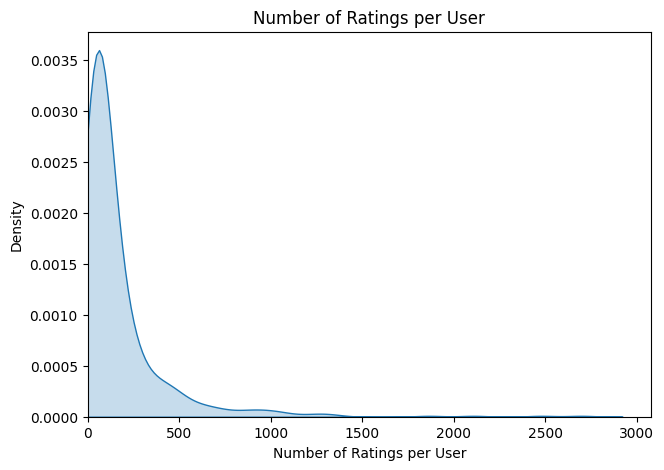

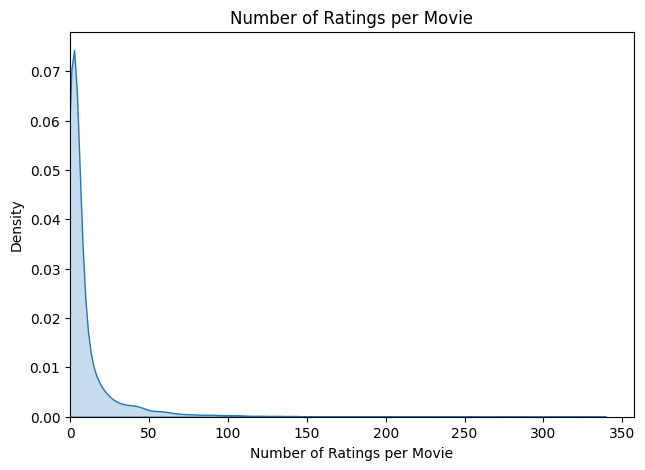

In [30]:
# create user interaction kde subplot 1
plt.figure(figsize=(16, 5))
plt.subplot(1, 2, 1)
sns.kdeplot(ratings_per_user, shade=True)

# format subplot 1
plt.xlim(0)
plt.xlabel('Number of Ratings per User')
plt.ylabel('Density')
plt.title('Number of Ratings per User')

# create movie interaction kde subplot 2
plt.figure(figsize=(16, 5))
plt.subplot(1, 2, 2)
sns.kdeplot(ratings_per_movie, shade=True)

# format subplot 2
plt.xlim(0)
plt.xlabel('Number of Ratings per Movie')
plt.ylabel('Density')
plt.title('Number of Ratings per Movie')

plt.show()

Most users rated less than 100 movies and most movies received less than 50 ratings.

# 5. Make Item to Item Recommendations based on $k$-Nearest Neighbors

To make our recommender system actionable, we need to assign similarity scores to the dataset. Here, we'll find the $k$ movies that have the most similar user interaction vectors with movie $i$.

In [31]:
# create a function that retrieves k-nearest neighbors of movie i based on cosine similarity scores
def rec_movies(movie_id, X, movie_mapper, movie_inv_mapper, k, metric='cosine'):
    '''
    
    FUNCTION: finds k-nearest neighbors of a movie i based on cosine similarity

    ARGS:
    movie_id - movie id of selected movie
    X - utility matrix 
    movie_mapper - mapper for locating movie in utility matrix
    movie_inv_mapper - mapper for locating movie in utility matrix
    k - number of similar movies to retrieve
    metric - distance metric for kNN calculations

    RETURNS:
    List of k similar movie Ids

    '''

    # first, transpose X to set movies as primary axis
    X = X.T
    # empty neighbor id list to locate similar titles
    neighbor_ids = []

    # map movie's id over our utility matrix
    movie_idx = movie_mapper[movie_id]
    movie_vec = X[movie_idx]
    if isinstance(movie_vec, (np.ndarray)):
        movie_vec = movie_vec.reshape(1, -1)

    # use k + 1 since KNN output includes movie id of interest
    kNN = NearestNeighbors(n_neighbors=k+1, algorithm='brute', metric=metric)
    kNN.fit(X)

    # find k neighbors
    neighbor = kNN.kneighbors(movie_vec, return_distance=False)
    for i in range(0, k):
        n = neighbor.item(i)
        neighbor_ids.append(movie_inv_mapper[n])
    neighbor_ids.pop(0)

    return neighbor_ids

Apply get similar movies function to movie id 1.

In [32]:
# first, create a movie titles dictionary, so we can match movie Ids with actual movie titles
movie_titles = dict(zip(movies['movieId'], movies['title']))

# return k neighbor Ids
similar_movies = rec_movies(1, X, movie_mapper, movie_inv_mapper, k=10)

# retrieve input movie's title
movie_title = movie_titles[1]

# convert neighbor Ids to movie titles
rec_titles = []
for i in similar_movies:
    rec_titles.append(movie_titles[i])

print(f'Because you watched {movie_title}: \n{rec_titles}')

Because you watched Toy Story (1995): 
['Toy Story 2 (1999)', 'Jurassic Park (1993)', 'Independence Day (a.k.a. ID4) (1996)', 'Star Wars: Episode IV - A New Hope (1977)', 'Forrest Gump (1994)', 'Lion King, The (1994)', 'Star Wars: Episode VI - Return of the Jedi (1983)', 'Mission: Impossible (1996)', 'Groundhog Day (1993)']


The recommended movies are similar as they're generally known to be family-friendly movies from the '90s.

# 6. Handling the Cold Start Problem

A recommender system that relies on CF to make recommendations is heavily reliant on user-item matches in the utility matrix. This is a problem because when there is not enough data in the matrix, no recommendation can be made based on a match, creating what's called the **cold start problem**.

To address this issue, we resort to content-based filtering to first gather data to fill our utility matrix with.

### Organize titles by item attributes (i.e. Genre)

In [33]:
# extract genres from movies dataframe for flagging
genres = set(g for genre in movies['genres'] for g in genre)

# flag genres in movies dataframe
for g in genres:
    movies[g] = movies['genres'].transform(lambda x: int(g in x))

# drop other columns
movie_genres = movies.drop(columns=['movieId', 'title', 'genres'])

movie_genres

,Romance,Sci-Fi,IMAX,(no genres listed),Fantasy,Western,Thriller,Musical,Film-Noir,Adventure,Drama,Horror,Mystery,Comedy,War,Children,Documentary,Animation,Action,Crime
0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,1,0,0
1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9737,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0
9738,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0
9739,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
9740,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0


We have 19 unique genres with 1 category where no genre is listed. Next, we want to group genres by similarity. We can do that by finding the cosine similarity of genres in our movie_genres dataframe.

In [34]:
# pass cosine similarity function through movie_genres dataframe
cosine_sim = cosine_similarity(movie_genres, movie_genres)

print(f'Cosine similarity matrix shape: {cosine_sim.shape} movies')
cosine_sim

Cosine similarity matrix shape: (9742, 9742) movies


array([[1.        , 0.77459667, 0.31622777, ..., 0.        , 0.31622777,
        0.4472136 ],
       [0.77459667, 1.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.31622777, 0.        , 1.        , ..., 0.        , 0.        ,
        0.70710678],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.31622777, 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.4472136 , 0.        , 0.70710678, ..., 0.        , 0.        ,
        1.        ]])

The result is a cosine similarity matrix containing values between 0 and 1 where values represent the degree of similarity between movies along the x and y axes.

### Create a movie finder function

In case, we want to get recommendations for a specific movie, a movie finder function would be useful to let a user explore siimlar titles. The problem right now is the titles in our dataset are followed by dates (i.e. 'Toy Story (1995)'), meaning a user would have to type that whole string out just to find similar movies to Toy Story. 

To make the recommender system more user-friendly, fuzzywuzzy is a Python package that uses a string matching algorithm that finds the most similar string inputted.

In [35]:
# create movie finder function
def movie_finder(title):
    titles = movies['title'].to_list()
    match = process.extractOne(title, titles)
    return match[0]

In [36]:
# test movie finder function
search_title = movie_finder('Toy Story')
search_title

'Toy Story (1995)'

Now that we can search for movies, we need a way to match that search to an index in the cosine similarity matrix. To do this, we create another index mapper. 

In [37]:
# create movie index mapper
movie_idx = dict(zip(movies['title'], list(movies.index)))
idx = movie_idx[search_title]
print(f'You searched: {search_title} ID: {idx}')

You searched: Toy Story (1995) ID: 0


With an ID match, we can now recommend similar titles using content-filtering.

In [38]:
# set number of recommendations
n_recommendations = 10

# first, retrieve list of ids and scores from our cosine similarity matrix
cos_sim_score = list(enumerate(cosine_sim[idx]))

# sort this list by most similar
cos_sim_score = sorted(cos_sim_score, key=lambda x: x[1], reverse=True)

# reduce list to cap at n_recommendations
cos_sim_score = cos_sim_score[1:(n_recommendations + 1)]

# extract just the id from the resulting tuples
similar_movies = [i[0] for i in cos_sim_score]

similar_movies

[1706, 2355, 2809, 3000, 3568, 6194, 6486, 6948, 7760, 8219]

Finally, test our recommender by generating 10 similar movies to Toy Story.

In [39]:
print(f'Because you watched: {search_title} \n{movies.title.iloc[similar_movies]}')

Because you watched: Toy Story (1995) 
1706                                          Antz (1998)
2355                                   Toy Story 2 (1999)
2809       Adventures of Rocky and Bullwinkle, The (2000)
3000                     Emperor's New Groove, The (2000)
3568                                Monsters, Inc. (2001)
6194                                     Wild, The (2006)
6486                               Shrek the Third (2007)
6948                       Tale of Despereaux, The (2008)
7760    Asterix and the Vikings (Astérix et les Viking...
8219                                         Turbo (2013)
Name: title, dtype: object


These titles all make for great family-friendly movies. We even have a sequel, Toy Story 2, and there are options to view more recently released movies.

To make things more streamlined, we will create a function that allows a user to search for a title and generate $n$ recommendations for that title.

In [40]:
def get_content_based_recommendations(title_string, n_recommendations=10):
    '''
    
    FUNCTION: gets n recommendations via content-filtering based on a title string

    ARGS:
    title string - user inputted title string
    n_recommendations - user set number of similar titles to be recommended

    RETURNS:
    list of similar titles
    
    '''

    # match the user inputted title string with a title in the dataset and extract its id
    title = movie_finder(title_string)
    idx = movie_idx[title]

    # match the id with the cosine similarity matrix
    cos_sim_score = list(enumerate(cosine_sim[idx]))
    cos_sim_score = sorted(cos_sim_score, key=lambda x: x[1], reverse=True)
    cos_sim_score = cos_sim_score[1:(n_recommendations + 1)]

    # list of similar movie ids
    similar_movies = [i[0] for i in cos_sim_score]
    
    print(f'Because you watched {title}: \n{movies.title.iloc[similar_movies]}')

In [41]:
# test content-based recommender
get_content_based_recommendations("Toy Story", n_recommendations=10)

Because you watched Toy Story (1995): 
1706                                          Antz (1998)
2355                                   Toy Story 2 (1999)
2809       Adventures of Rocky and Bullwinkle, The (2000)
3000                     Emperor's New Groove, The (2000)
3568                                Monsters, Inc. (2001)
6194                                     Wild, The (2006)
6486                               Shrek the Third (2007)
6948                       Tale of Despereaux, The (2008)
7760    Asterix and the Vikings (Astérix et les Viking...
8219                                         Turbo (2013)
Name: title, dtype: object


# 7. Dimensionality Reduction with Matrix Factorization

We can use Matrix Factorization (MF) to discover any latent features between users and titles, giving a more compact representation of user tastes and item attributes. MF is particularly relevant to sparse matrices because it can enhance the quality of recommendations by imputing missing values in the dataset.

We can reduce our utility matrix into 2 factor matrices:
$$X_{mn} \approx P_{mk} \times Q^{T}_{nk} = \hat{X}$$

\begin{align*}
(\text{n\_users}, \text{k}) \\
(\text{k}, \text{n\_items})
\end{align*}

We can use sklearn's TruncatedSVD to start dimensionality reduction.

In [42]:
# set svd parameters
svd = TruncatedSVD(n_components=20, n_iter=10)

# create item matrix by fitting svd to the transposed utility matrix
Q = svd.fit_transform(X.T)

print(f'Item matrix with {Q.shape[0]} movies and {Q.shape[1]} components')

Item matrix with 9724 movies and 20 components


Test compressed recommender system.

In [43]:
# set Toy Story movie id as 1 because our movie mapper doesn't start from 0
movie_id = 1

# return ids of similar movies
similar_movies = rec_movies(movie_id, Q.T, movie_mapper, movie_inv_mapper, k=10, metric='cosine')

# match id with movie title
movie_title = movie_titles[movie_id]

# recommend movies
print(f'Because you watched {movie_title}: \n{movies.title.iloc[similar_movies]}')

Because you watched Toy Story (1995): 
586     Haunted World of Edward D. Wood Jr., The (1996)
480                            Terminal Velocity (1994)
588                        Great White Hype, The (1996)
1270                  I Love You, I Love You Not (1996)
1073                               Jerry Maguire (1996)
1265                               Sliding Doors (1998)
356                        Age of Innocence, The (1993)
260                                    Quiz Show (1994)
1197                       In the Company of Men (1997)
Name: title, dtype: object


These results are from our compressed kNN movie-factor matrix where we've reduced the number of dimensions to 20 latent features. The recommendations differ compared to the uncompressed version. This can be accounted for by increasing the n_components to an optimal setting that isn't too computationally complex and still returns relevant recommendations. 

### Evaluation Metrics

- RMSE
- Precision @K; Recall @K